In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import all the missing packages
import glob
import os
import saqqara
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SequentialSampler
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, "../simulator/")
from simulator import LISA_AET


def get_data_npy_dataset(data_dir):
    if not os.path.exists(data_dir):
        raise ValueError(f"Data directory {data_dir} does not exist.")
    print(f"[INFO] Loading data from {data_dir}")
    DATA_FILES = glob.glob(data_dir + "/cg_data_*.npy")
    DATA_FILES = sorted(DATA_FILES, key=lambda x: str(x.split("_")[-1].split(".")[0]))

    # Compute total number of simulations
    n_simulations = len(DATA_FILES) * 128
    print(f"[INFO] Total number of simulations: {n_simulations}")
    data_shape = np.load(DATA_FILES[0]).shape[1:]
    print(f"data shape: {data_shape}")
    data_dataset = saqqara.NPYDataset(file_paths=DATA_FILES)
    return data_dataset


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
config = saqqara.load_settings('../configs/training_resampling_signal.yaml')

In [4]:
config = saqqara.load_settings('../configs/training_resampling_signal.yaml')
sim = LISA_AET(config)

Detector setup complete
Noise matrices computed
Response computed
Coarse graining setup complete


In [5]:
resampling_store = get_data_npy_dataset("../data/resampling_data_with_signal")
resampling_dataset = saqqara.RandomSamplingDataset(resampling_store)
training_dataset = saqqara.ResamplingTraining(sim, resampling_dataset)

[INFO] Loading data from ../data/resampling_data_with_signal
[INFO] Total number of simulations: 51200
data shape: (6, 945, 3)


In [6]:
sys.path.insert(0, "../inference/")
from networks import SignalAET
from dataloader import get_resampling_dataloader

In [8]:
config["train"]["store_name"]

'data/resampling_data_with_signal'

In [9]:
config["train"]["store_name"] = "../data/resampling_data_with_signal"
train_dl, val_dl = get_resampling_dataloader(sim, config)

[INFO] Loading data from ../data/resampling_data_with_signal
[INFO] Total number of simulations: 51200
data shape: (6, 945, 3)


In [43]:
signal_dataset = get_data_npy_dataset("../data/signal_store")
tm_dataset = get_data_npy_dataset("../data/tm_store")
oms_dataset = get_data_npy_dataset("../data/oms_store")

[INFO] Loading data from ../data/signal_store
[INFO] Total number of simulations: 2432
data shape: (945, 3)
[INFO] Loading data from ../data/tm_store
[INFO] Total number of simulations: 2432
data shape: (945, 3)
[INFO] Loading data from ../data/oms_store
[INFO] Total number of simulations: 2432
data shape: (945, 3)


In [14]:
data = training_dataset[0]
sample = sim.sample(conditions={'z': np.array(data['z'])})

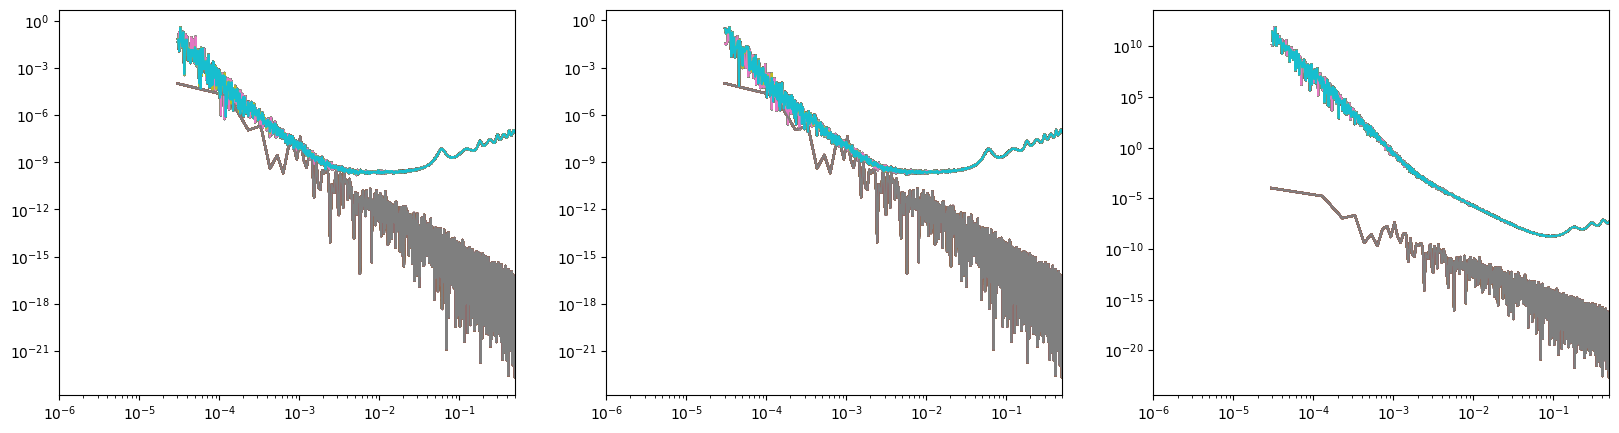

In [28]:
fig = plt.figure(figsize=(20, 5))
for _ in range(100):
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        plt.loglog(sim.coarse_grained_f, data['data'][:,i])
        plt.loglog(sim.f_vec[::100], np.array(sample['quadratic_signal_AET'][::100, i] / sim.response_AET[::100, i]))
        plt.loglog(sim.coarse_grained_f, sample['coarse_grained_data'][:, i])
        plt.loglog(sim.coarse_grained_f, sample['full_coarse_grained_data'][:, i])
        plt.xlim(1e-6, 5e-1)

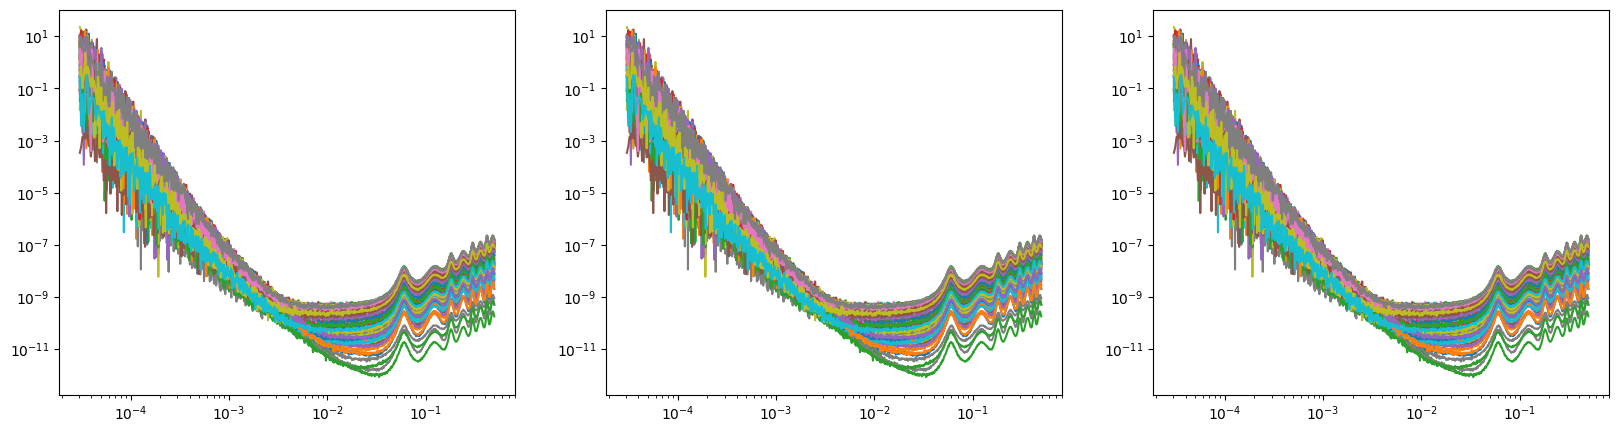

In [28]:
fig = plt.figure(figsize=(20, 5))
for _ in range(100):
    data = training_dataset[0]['data']
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        plt.loglog(sim.coarse_grained_f, data[:, 0])

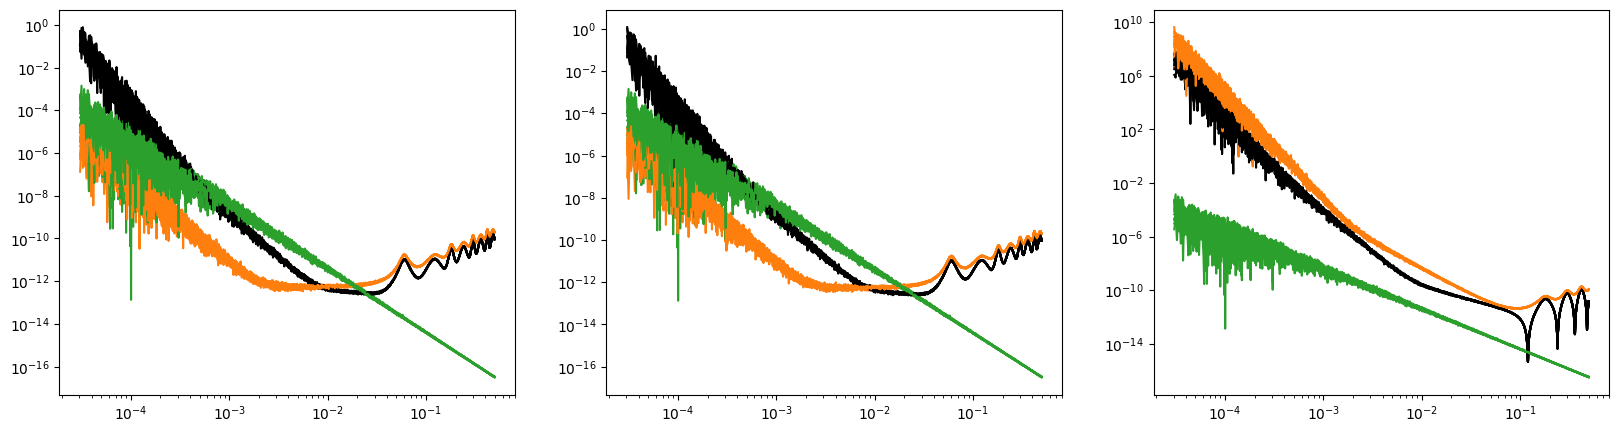

In [9]:
fig = plt.figure(figsize=(20, 5))
for _ in range(10):
    choice = np.random.randint(0, len(resampling_store))
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        plt.loglog(sim.coarse_grained_f, resampling_store[choice][0, :, i], label="TM", c='k')
        plt.loglog(sim.coarse_grained_f, resampling_store[choice][1, :, i], label="OMS", c='C1')
        plt.loglog(sim.coarse_grained_f, resampling_store[choice][2, :, i], label="Signal", c='C2')

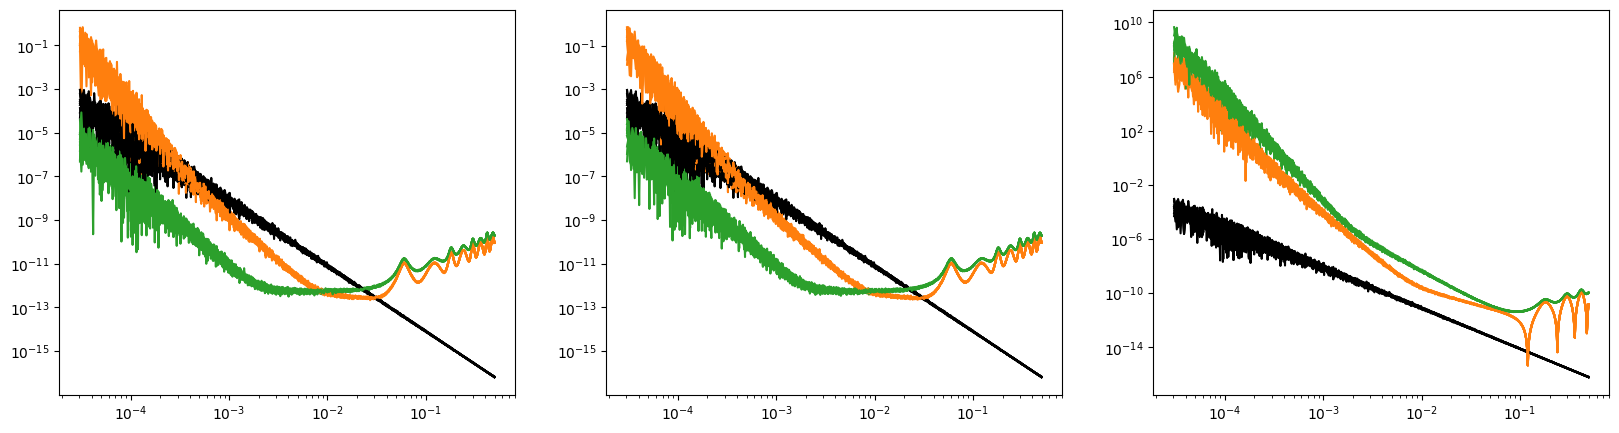

In [41]:
fig = plt.figure(figsize=(20, 5))
for _ in range(10):
    signal_choice = np.random.choice(len(signal_dataset))
    tm_choice = np.random.choice(len(tm_dataset))
    oms_choice = np.random.choice(len(oms_dataset))
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        plt.loglog(sim.coarse_grained_f, signal_dataset[signal_choice][:, i], label="Signal", c='k')
        plt.loglog(sim.coarse_grained_f, tm_dataset[tm_choice][:, i], label="TM", c='C1')
        plt.loglog(sim.coarse_grained_f, oms_dataset[oms_choice][:, i], label="OMS", c='C2')

In [208]:
from torch.utils.data import Dataset
class ResamplingDataset(Dataset, dict):
    def __init__(self, signal_store, tm_store, oms_store):
        self.sim = sim
        self.datasets = {
            "signal": signal_store,
            "tm": tm_store,
            "oms": oms_store,
        }
        self.signal = signal_store
        self.tm = tm_store
        self.oms = oms_store
        self.total_length = signal_store.total_length

    def __len__(self):
        return self.total_length
    
    def sample_z(self, n_samples):
        return sim.sample(n_samples, targets=["z"])["z"]

    def __getitem__(self, idx):
        if isinstance(idx, int):
            signal_idx = np.random.randint(len(self.signal))
            tm_idx = np.random.randint(len(self.tm))
            oms_idx = np.random.randint(len(self.oms))
            signal = self.signal[signal_idx]
            tm = self.tm[tm_idx]
            oms = self.oms[oms_idx]
            return {
                "signal": np.array(signal),
                "tm": np.array(tm),
                "oms": np.array(oms),
            }
        elif isinstance(idx, slice):
            start = idx.start or 0
            stop = idx.stop or self.total_length
            step = idx.step or 1
            if start < 0:
                start = self.total_length + start
            if stop < 0:
                stop = self.total_length + stop
            if stop > self.total_length:
                raise IndexError
            if start < 0:
                raise IndexError
            # work out how many samples there will be
            n_samples = len(range(start, stop, step))
            signal_samples = []
            tm_samples = []
            oms_samples = []
            for _ in range(n_samples):
                signal_idx = np.random.randint(len(self.signal))
                tm_idx = np.random.randint(len(self.tm))
                oms_idx = np.random.randint(len(self.oms))
                signal_samples.append(self.signal[signal_idx])
                tm_samples.append(self.tm[tm_idx])
                oms_samples.append(self.oms[oms_idx])
            return {
                "signal": np.array(signal_samples),
                "tm": np.array(tm_samples),
                "oms": np.array(oms_samples),
            }
        elif isinstance(idx, tuple):
            batch = []
            for _idx in idx:
                if isinstance(_idx, int):
                    batch.append(self.__getitem__(_idx))
                elif isinstance(_idx, slice):
                    batch.append(self.__getitem__(_idx))
            signal_arrs = []
            tm_arrs = []
            oms_arrs = []
            for b in batch:
                if len(b["signal"].shape) > 2:
                    signal_arrs.append(b["signal"])
                    tm_arrs.append(b["tm"])
                    oms_arrs.append(b["oms"])
                else:
                    signal_arrs.append(b["signal"].unsqueeze(0))
                    tm_arrs.append(b["tm"].unsqueeze(0))
                    oms_arrs.append(b["oms"].unsqueeze(0))
            return {
                "signal": np.vstack(signal_arrs),
                "tm": np.vstack(tm_arrs),
                "oms": np.vstack(oms_arrs),
            }
        elif isinstance(self, str):
            return self.datasets[idx]
        else:
            raise ValueError("Invalid index type")

In [262]:
import torch
class SaqqaraDataset(Dataset, dict):
    def __init__(self, sim, resampling_dataset):
        self.prior = sim.prior
        self.f_over_pivot = sim.coarse_grained_f / np.sqrt(sim.f_vec[0] * sim.f_vec[-1])
        self.resampling_dataset = resampling_dataset
        self.total_length = len(self.resampling_dataset)

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        data = self.resampling_dataset[idx]
        if len(data["signal"].shape) > 2:
            z = self.prior.sample(data["signal"].shape[0])
            out = {
                "z": z,
                "data": np.einsum("ij,ijk->ijk", np.power(self.f_over_pivot[:, None], z[:, 1]).T, np.einsum("i,ijk->ijk", 10 ** z[:, 0] / 10 ** (-11.0), data["signal"]))
                + np.einsum("i,ijk->ijk", z[:, 2]**2, data["tm"])
                + np.einsum("i,ijk->ijk", z[:, 3]**2, data["oms"]),
            }
        else:
            z = self.prior.sample()
            out = {
                "z": z,
                "data": np.einsum("i,ij->ij", self.f_over_pivot**z[1], 10 ** z[0] / 10 ** (-11.0) * data["signal"])
                + z[2]**2 * data["tm"]
                + z[3]**2 * data["oms"],
            }
        return out

In [263]:
resampling_dataset = ResamplingDataset(signal_dataset, tm_dataset, oms_dataset)
saqqara_dataset = SaqqaraDataset(sim, resampling_dataset)

In [264]:
def setup_dataloaders(
    dataset,
    total_size=None,
    train_fraction=0.8,
    val_fraction=0.2,
    num_workers=0,
    batch_size=64,
):
    if total_size is None:
        total_size = len(dataset)
    if total_size > len(dataset):
        raise ValueError(
            f"Total size {total_size} is larger than dataset size {len(dataset)}"
        )
    indices = list(range(len(dataset)))
    train_idx, val_idx = int(np.floor(train_fraction * total_size)), int(
        np.floor((train_fraction + val_fraction) * total_size)
    )
    train_indices, val_indices = indices[:train_idx], indices[train_idx:val_idx]
    # train_sampler, val_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(val_indices)
    train_sampler, val_sampler = SequentialSampler(train_indices), SequentialSampler(
        val_indices
    )
    train_dataloader = DataLoader(
        dataset=dataset,
        drop_last=True,
        sampler=train_sampler,
        num_workers=int(num_workers),
        batch_size=int(batch_size),
    )
    val_dataloader = DataLoader(
        dataset=dataset,
        drop_last=True,
        sampler=val_sampler,
        num_workers=int(num_workers),
        batch_size=int(batch_size),
    )
    return train_dataloader, val_dataloader

In [265]:
train_dl, val_dl = setup_dataloaders(saqqara_dataset, total_size=2000, batch_size=64)

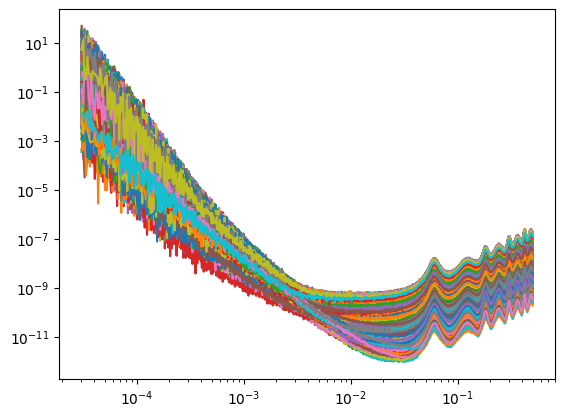

In [289]:
for _ in range(1000):
    plt.loglog(sim.coarse_grained_f, saqqara_dataset[0]["data"][:, 0])

/Users/james/Code/mambaforge/envs/saqqara-3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)


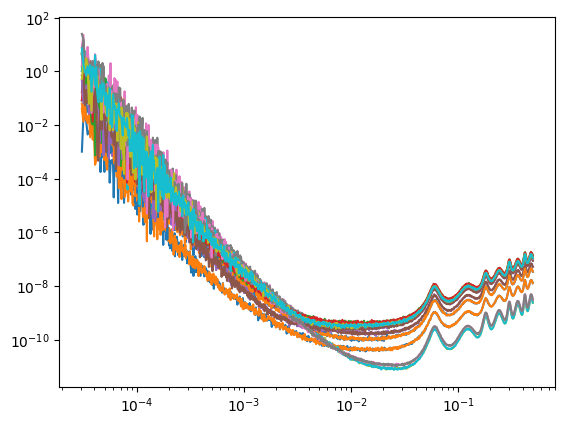

In [297]:
for _ in range(10):
    example = saqqara_dataset[0]
    data = sim.sample(conditions={"z": example["z"]})
    plt.loglog(sim.coarse_grained_f, data["coarse_grained_data"][:, 0])
    plt.loglog(sim.coarse_grained_f, example["data"][:, 0])

In [295]:
import tqdm
for _ in tqdm.tqdm(range(10000)):
    example = saqqara_dataset[0]

100%|██████████| 10000/10000 [00:04<00:00, 2049.05it/s]


In [253]:
for batch in train_dl:
    print(batch["data"].shape)

torch.Size([64, 945, 3])
torch.Size([64, 945, 3])
torch.Size([64, 945, 3])
torch.Size([64, 945, 3])
torch.Size([64, 945, 3])
torch.Size([64, 945, 3])
torch.Size([64, 945, 3])
torch.Size([64, 945, 3])
torch.Size([64, 945, 3])
torch.Size([64, 945, 3])
torch.Size([64, 945, 3])
torch.Size([64, 945, 3])
torch.Size([64, 945, 3])
torch.Size([64, 945, 3])
torch.Size([64, 945, 3])
torch.Size([64, 945, 3])
torch.Size([64, 945, 3])
torch.Size([64, 945, 3])
torch.Size([64, 945, 3])
torch.Size([64, 945, 3])
torch.Size([64, 945, 3])
torch.Size([64, 945, 3])
torch.Size([64, 945, 3])
torch.Size([64, 945, 3])
torch.Size([64, 945, 3])


In [223]:
z = np.ones((2, 4))
cg_f = np.ones(10)
data = np.ones((2, 10, 3))

In [228]:
np.einsum("i,ijk->ijk", z[:, 0]**2, data).shape

(2, 10, 3)

In [261]:
z = sim.prior.sample(2)
np.power(sim.coarse_grained_f[:, None], z[:, 1]).shape
print(sim.coarse_grained_f**z[0, 1])
print(sim.coarse_grained_f**z[1, 1])
print(np.power(sim.coarse_grained_f[:, None], z[:, 1]).T)

[505.74307593 496.06724415 486.87039626 478.11514671 469.76803308
 461.79900487 454.18099124 446.88953354 439.90247161 433.19967478
 426.76281027 420.57514295 414.6213616  408.8874277  403.36044329
 398.02853515 392.88075302 387.90697984 383.09785245 378.44469121
 373.93943752 369.57459818 365.34319559 361.23872334 357.25510625
 353.38666452 349.62808145 345.97437427 342.4208678  338.96317062
 335.59715339 332.31892923 329.12483577 326.01141889 322.97541779
 320.01375139 317.12350586 314.30192319 311.54639069 308.85443137
 306.22369504 303.65195012 301.13707615 298.67705674 296.2699732
 293.91399853 291.6073919  289.34849355 287.13571998 284.96755958
 282.84256847 280.75936669 278.71663463 276.71310969 274.74758317
 272.81889736 270.92594284 269.06765593 267.24301628 265.45104468
 263.69080095 261.96138195 260.26191977 258.59157997 256.94955997
 255.33508747 253.74741907 252.18583883 250.64965704 249.13820899
 247.65085381 246.18697341 244.74597142 243.32727228 241.93032026
 240.554578